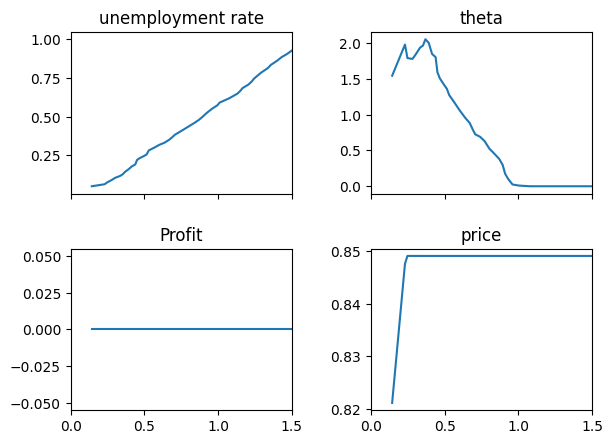

In [1]:
# 0813 V3 could show the results, but with several details to revise.
# Step 1: redefine class of firm by incorporating job finding rate and job separation rate
import random
import math
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000
simulation_years = 1000

birth_rate, death_rate = 0.011, 0.23014
retirement_age, death_age = 65, 80

initial_participation_rate, initial_aging_rate, initial_unemployment_rate = 0.7, 0.1, 0.05

# Initialize workforce data    
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)

job_finding_rate, job_separation_rate = 0.2, 0.01

phi, wage, y, y_u, y_a = 0.6, 0.7, 1, 0.6, 0.4

# labor_matching: m(u,v) = kappa*u**zeta*v**(1-zeta)
# q(theta) = m(u,v) / v = kappa*theta**(-zeta), f(theta) = kappa*theta**(1-zeta)
kappa, zeta = 0.5, 0.35
# goods_matching: N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

psi_a, psi_u, psi_e = 0.1, 0.1, 0.9

# Initialize population
newborn_coh, senior_coh, young_coh, workforce_coh, emp_coh, unemp_coh = [],[],[],[],[],[]

initial_unemp = int(initial_workforce * initial_unemployment_rate)

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed
    
    def update_age(self):
        self.age += 1
        
    def is_newborn(self):
        return self.age == 0
    
    def is_young(self):
        return self.age < 15
    
    def is_workforce(self):
        return 14 < self.age < retirement_age
    
    def is_senior(self):
        return self.age >= retirement_age 

    def is_unemployed(self):
        return not self.employed
    
    def is_employed(self):
        return self.employed
    
# Parameters for firm-related variables
#initial_price = 0.7
#initial_vacancy = 3
#initial_vacancy_cost = 0.6
random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(0, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_depen = list(itertools.chain(newborn_coh, young_coh))
pop = list(itertools.chain(young_depen, workforce_coh, senior_coh))

cohorts = [[len(young_depen)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]

class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, U, E): # U, V mean the total measure of unemployed workers and the job vacancy in the market.
        hire_or_fire_decision = self.price > self.vacancy_cost
        num_new_vacancies = random.randint(1, 5)
        '''
        #m = kappa*U**zeta*V**(1-zeta)
        m = min(U, V)
        numerator = (self.price - self.vacancy_cost) - y_u
        
        denominator = self.vacancy_cost * len(firms)
        #print(m)
        num_new_vacancies = int(m * (1 - phi) * (y * numerator) / denominator)
        num_new_vacancies = int(m/len(firms)*(1-phi)*(y*(self.price-self.vacancy_cost)-y_u)/(self.vacancy_cost+1e-6))
        
        '''
        
        if hire_or_fire_decision:  # Hiring decision
            self.job_vacancy += num_new_vacancies
            
            # count of employed in the labor market
            num_hired = min(int(U * job_finding_rate / len(firms)), self.job_vacancy)
            self.job_vacancy -= num_hired
            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(E * job_separation_rate / len(firms))
            self.job_vacancy -= num_fired
            return 0, num_fired, self.job_vacancy

    
    def update_prices(self, total_demand):
 
        for firm in firms:
            firm.price = firm.price * (1 + total_demand / len(firms))

        self.price = sum(firm.price for firm in firms) / len(firms)
        
        prof = (self.price - self.vacancy_cost) * total_demand/len(firms) \
        if self.price >= self.vacancy_cost else 0
    
        return self.price, prof
        
# N(u,v) = min(b,s), where b = (n-u)*(1+psi_e)+u*(1+psi_u)+a*(1+psi_a),s = n-u

class GoodsMarket:
    def __init__(self, firms, N, U, A):
        self.firms = firms
        self.N = N
        self.U = U
        self.A = A
        self.S = N-U
        self.B = (N-U)*(1+psi_e)+U*(1+psi_u)+A*(1+psi_a)
        self.niu = min(1, self.S/self.B)
        
    def calculate_demand(self):
        total_demand = self.A*(1+psi_a)/self.B*(1-2*psi_a/(1+psi_a))*y_a +\
        (self.N-self.U)*(1+psi_e)/self.B*(1-2*psi_e/(1+psi_e))*wage +\
        self.U*(1+psi_u)/self.B*(1-2*psi_u/(1+psi_u))*y_u
        '''
        for consumer in consumers:
            if consumer.is_senior():
                total_demand += self.A*(1+psi_a)/self.B*(1-2*psi_a/(1+psi_a))*y_a
            elif consumer.is_employed():
                total_demand += (self.N-self.U)*(1+psi_e)/self.B*(1-2*psi_e/(1+psi_e))*wage
            elif consumer.is_unemployed():
                total_demand += self.U*(1+psi_u)/self.B*(1-2*psi_u/(1+psi_u))*y_u
        '''
        return total_demand



class LaborMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_unemployed(self):
        Un = sum(1 for person in workforce_coh if person.is_unemployed())
        return Un

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())
   
    def new_workstatus(self):
        A = sum(1 for person in senior_coh)
        N = labor_market.calculate_unemployed()+labor_market.calculate_employed()
        goods_market = GoodsMarket(self.firms, N, labor_market.calculate_unemployed(), A)
        new_emp, new_unemp, tot_job = 0, 0, 0
        
        for firm in self.firms:
            hired, fired, job = firm.hire_or_fire(labor_market.calculate_unemployed(), \
                                                  labor_market.calculate_employed())
            new_emp += hired
            new_unemp += fired
            tot_job += job
        return new_emp, new_unemp, tot_job
    

old_aged_dependency_ratios = [initial_senior / initial_workforce]

# Initialize the goods market with firms
random.seed(2)
num_firms = 10
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0, 0.5)) for _ in range(num_firms)]
goods_market = GoodsMarket(firms, len(workforce_coh), len(unemp_coh), len(senior_coh))
price_history = [sum(firm.price for firm in firms) / len(firms)]

# Initialize the LaborMarket with firms and initial_workforce
labor_market = LaborMarket(firms)  # Pass initial_workforce here

# Simulation loop
n = simulation_years
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time


initial_vacancy = labor_market.new_workstatus()[2]

theta = [initial_vacancy / labor_market.calculate_unemployed()]

prices_in_goods_market = [sum(firm.price for firm in firms) / len(firms)]



tot_dem = [goods_market.calculate_demand(pop)]
firm_profits = [goods_market.calculate_demand(pop) * \
                sum(firm.price - firm.vacancy_cost for firm in firms if firm.price > firm.vacancy_cost) / len(firms)]


random.seed(3)
for year in range(1, n): 
  
    # Create lists to store updated cohorts for this year
    updated_newborn_coh, updated_senior_coh, updated_young_coh = [], [], []
    updated_workforce_coh, updated_emp_coh, updated_unemp_coh = [], [], []

    # Update age and employment status for each person
    for person in newborn_coh:
        person.update_age()
        if person.age == 1:
            updated_young_coh.append(person)

    for person in young_coh:
        person.update_age()
        if person.is_young():
            updated_young_coh.append(person)
        if person.is_workforce():
            updated_workforce_coh.append(person)
            updated_unemp_coh.append(person)

    for person in workforce_coh:
        person.update_age()
        if person.is_workforce():
            updated_workforce_coh.append(person)
            if person.is_unemployed():
                updated_unemp_coh.append(person)
            if person.is_employed():
                updated_emp_coh.append(person)
        else:
            updated_senior_coh.append(person)
        
    for person in senior_coh:
        person.update_age()
        updated_senior_coh.append(person)
        
    # Update the number of senior citizens considering the death rate
    death = math.ceil(len(senior_coh) * death_rate)
    
    # Randomly shuffle the list
    random.shuffle(senior_coh)

    # Remove the first death number of agents in senior_coh (since the list is shuffled, this will effectively be random)
    removed_senior_coh = senior_coh[:death]

    # Update the original list by keeping only the remaining senior_coh
    senior_coh = senior_coh[death:]

    newborn_this_year = math.ceil((len(senior_coh) + len(unemp_coh) + len(emp_coh)) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        updated_newborn_coh.append(person)
        
    # Update the cohort lists for this year
    newborn_coh = updated_newborn_coh
    senior_coh = updated_senior_coh
    young_coh = updated_young_coh
    workforce_coh = updated_workforce_coh
    emp_coh = updated_emp_coh
    unemp_coh = updated_unemp_coh
    
    pop = list(itertools.chain(newborn_coh, young_coh, workforce_coh, senior_coh))
    #print(len(workforce_coh)/len(pop))
    
    # Goods market dynamics
    total_demand = goods_market.calculate_demand(pop)
    tot_dem.append(total_demand)
    
    # Calculate new employment and unemployment rates for this year
    new_unemployment_rate = len(unemp_coh) / (len(unemp_coh) + len(emp_coh))
    unemployment_rates.append(new_unemployment_rate)
       
    # Store the values in cohorts list
    my_list = [len(young_coh)+len(newborn_coh), len(unemp_coh), len(emp_coh), len(senior_coh)]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = len(pop)
   
    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = len(senior_coh) / (len(unemp_coh) + len(emp_coh)+1e-6)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)

    # Calculate firm-related variables
    num_job_vacancies = labor_market.new_workstatus()[2]
    #job_vacancies.append(num_job_vacancies)
    
    total_firm_profits = 0
    for firm in firms:
        #firm_price = firm.update_prices(total_demand)[0]
        #print(firm_price-firm.vacancy_cost)
        #if firm_price > firm.vacancy_cost:
        total_firm_profits += firm.update_prices(total_demand)[1]
                
    firm_profits.append(total_firm_profits)
    
    # Calculate labor market tightness
    updated_theta = num_job_vacancies / (len(unemp_coh)+1e-6)
    theta.append(updated_theta)
    
    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    total_prices_in_goods_market = sum(firm.update_prices(total_demand)[0] for firm in firms) / len(firms)
    prices_in_goods_market.append(total_prices_in_goods_market)

# Plot results
fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].plot(old_aged_dependency_ratios, unemployment_rates, label="Unemployment Rate")
axs[0, 0].set_title('unemployment rate')
axs[0, 1].plot(old_aged_dependency_ratios, theta, label="Labor Market Tightness")
axs[0, 1].set_title('theta')
axs[1, 0].plot(old_aged_dependency_ratios, firm_profits, label="Firm Profits")
axs[1, 0].set_title('Profit')
axs[1, 1].plot(old_aged_dependency_ratios, prices_in_goods_market, label="Prices in Goods Market")
axs[1, 1].set_title('price')

plt.xlim(0, 1.5)
fig.tight_layout(pad=2.0)
plt.show()


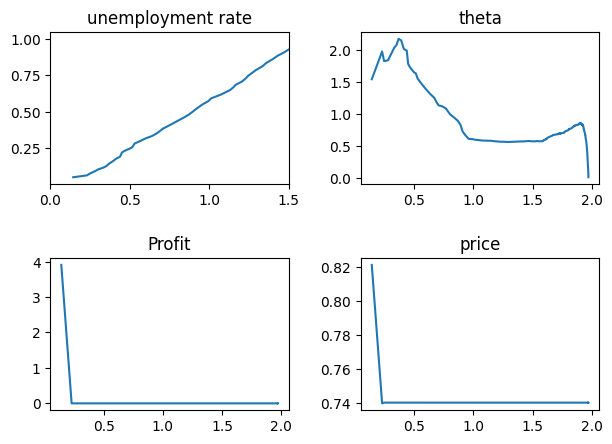

In [4]:
tot_dem

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
